In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import os
import pandas as pd
import pysam
import numpy as np
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import (symmertic_insertion_seqs_gen, reference_seqs_gen)
from akita_utils.tsv_utils import split_df_equally
from akita_utils.tsv_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

CTCT_table = "./picked_for_plotting.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

### Adding parameters to the CTCF table to perform insertions

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df.sort_values(by="SCD_B")
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

# boundary exp
flank_length = 30
orient_list = ["<>"]
background_indices_list = [x for x in range(10)]
spacing_list=[60]

# adding orientation
B_seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
B_seq_coords_df = add_background(
    B_seq_coords_df, 
    background_indices_list
    )

# adding flank_bp, and spacer_bp
B_seq_coords_df = add_const_flank_and_diff_spacer(
        B_seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [7]:
# dot exp
flank_length = 30
orient_list = ["><"]
background_indices_list = [x for x in range(10)]
spacing_list=[199970]

# adding orientation
D_seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
D_seq_coords_df = add_background(
    D_seq_coords_df, 
    background_indices_list
    )

D_seq_coords_df = add_const_flank_and_diff_spacer(
        D_seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [8]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

### Reference (background) predictions

In [9]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 23s 4s/step


### Boundary-scenario predictions

In [10]:
B_preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(B_seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

### Dot-scenario predictions

In [11]:
D_preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(D_seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [ ]:
# from akita_utils.stats_utils import calculate_SCD
# from akita_utils.analysis_utils import plot_map
# from akita_utils.utils import ut_dense

### Collecting predicted vectors

In [12]:
num_experiments = len(B_seq_coords_df)
num_binding_sites = len(B_seq_coords_df["seq_index"].unique())
num_scenarios = 2  # B and D
num_backgrounds = 10
num_targets = 6
length_of_prediction_vector = 130305

summary_matrix = np.zeros((num_binding_sites, num_scenarios, num_backgrounds, num_targets, length_of_prediction_vector))

In [13]:
for exp_index in range(num_experiments):
    print(f"experiment {exp_index}")
    seq_index = B_seq_coords_df.iloc[exp_index].seq_index
    print("seq_index: ", seq_index)
    bg_index = B_seq_coords_df.iloc[exp_index].background_index
    
    B_prediction_matrix = B_preds_stream[exp_index]
    D_prediction_matrix = D_preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]
    
    B_difference_matrix = B_prediction_matrix - reference_prediction_matrix
    D_difference_matrix = D_prediction_matrix - reference_prediction_matrix
    
    # Accumulate differences for each target
    for target_index in range(num_targets):
        summary_matrix[seq_index, 0, bg_index, target_index, :] += B_difference_matrix[:, target_index]
        summary_matrix[seq_index, 1, bg_index, target_index, :] += D_difference_matrix[:, target_index]
  

experiment 0
seq_index:  0
4/4 [==============================] - 69s 17s/step
experiment 1
seq_index:  1
experiment 2
seq_index:  2
experiment 3
seq_index:  3
experiment 4
seq_index:  4
experiment 5
seq_index:  5
experiment 6
seq_index:  0
experiment 7
seq_index:  1
experiment 8
seq_index:  2
experiment 9
seq_index:  3
experiment 10
seq_index:  4
experiment 11
seq_index:  5
experiment 12
seq_index:  0
experiment 13
seq_index:  1
experiment 14
seq_index:  2
experiment 15
seq_index:  3
experiment 16
seq_index:  4
experiment 17
seq_index:  5
experiment 18
seq_index:  0
experiment 19
seq_index:  1
experiment 20
seq_index:  2
experiment 21
seq_index:  3
experiment 22
seq_index:  4
experiment 23
seq_index:  5
experiment 24
seq_index:  0
experiment 25
seq_index:  1
experiment 26
seq_index:  2
experiment 27
seq_index:  3
experiment 28
seq_index:  4
experiment 29
seq_index:  5
experiment 30
seq_index:  0
experiment 31
seq_index:  1
experiment 32
seq_index:  2
4/4 [=============================

In [15]:
# averaging over backgrounds and targets
summary_matrix = summary_matrix.mean(axis=(2, 3))

plotting: sequence=0
plotting: sequence=1
plotting: sequence=2
plotting: sequence=3
plotting: sequence=4
plotting: sequence=5
plotting: sequence=0
plotting: sequence=1
plotting: sequence=2
plotting: sequence=3
plotting: sequence=4
plotting: sequence=5


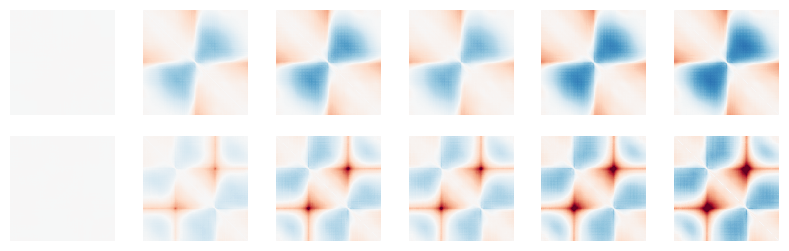

In [16]:
rows = ["boundary", "dot"]
num_sequences = 6
num_scenarios = 2

fig, axs = plt.subplots(num_scenarios, num_sequences, figsize=(10,3))

for scenario_idx in range(num_scenarios):
    for seq_idx in range(num_sequences):
        print(f"plotting: sequence={seq_idx}")
        
        plot_matrix = ut_dense(np.expand_dims(summary_matrix[seq_idx, scenario_idx, :], 1), diagonal_offset=2)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[scenario_idx, seq_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )
        
# plt.savefig("./plots/dot_boundary_maps.pdf", format="pdf", bbox_inches="tight")
plt.savefig("./plots/dot_boundary_maps.png", format="png", bbox_inches="tight")

plt.show()

In [17]:
genome_open.close()